# EXERCISE 4. Estimate hyperparameters for priors

Now, we will move on to estimate hyperparameters for the priors of the parameters in our model. 
It can take quite a bit of time to run, so I already ran the simulation for you, so we can focus on exploring the results.

If you are interested in how to run it, check the file `04-fitting-hierarchical.py` in the `exercises` or `solutions` folder.

More information about the method as well can be found in the documentation of the `cpm` package, in the section about hierarchical models. Briefly, we use an Expectation Maximisation algorithm to estimate the hyperparameters of the priors for the parameters in our model. The algorithm iteratively updates the hyperparameters until convergence. In plain language, it runs four times using different starting points for the hyperparameters, checking whether there is any change from one iteration to the next, and if not, it stops. The result is a set of hyperparameters that can be used to define the priors for the parameters in our model.

Let us move on to the code:


In [ ]:
import warnings

import cpm
import cpm.datasets as datasets
from cpm.generators import Parameters, Value

import numpy
import pandas as pd
import functions as f ## I prepped some models here, so you can use them directly

## plotting libraries
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
## Hierarchical fitting can take a lot of time depending on your setup, so I ran the simulation for you already, so we can focus on exploring the results. 
hyperparameters = pd.read_csv('04-fitting-hierarchical-hyperparameters.csv')
hyperparameters.head()

So, the first column is a leftover from the way I saved the file, ignore it for now.

Then we have the following columns of interest:
- `chain`: the chain number, we ran 4 chains in total. Each chain starts from a different set of hyperparameters.
- `iteration`: the iteration number, we ran 40 iterations in total, but the optimisation can stop earlier.
- `parameter`: the name of the parameter, we have 2 parameters in our model.
- `mean`: the mean of the hyperparameter for the parameter.
- `sd`: the standard deviation of the hyperparameter for the parameter.
- `lme`: the log model evidence (a maximum likelihood estimate) that takes into account both the individual fits and the hyperparameters.

The remaining columns give us some extra information about the optimisation process, but we do not want to complicate things too much, so we will not focus on them now.

## EXERCISE 4.1: Explore the results

First, we will need to see whether our  hyperparameters converged. We can start doing that by plotting the log model evidence over the iterations for each chain and parameter. 

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=hyperparameters.drop_duplicates(subset=['chain', 'iteration']),
    x='iteration',
    y='lme',
    hue='chain',
    marker='o',
    markersize=10,
    palette='tab10',
)
plt.title('Log Model Evidence (lme) over Iterations for Each Chain')
plt.xlabel('Iteration')
plt.ylabel('Log Model Evidence (lme)')
plt.legend(title='Chain')
plt.tight_layout()

So, what is the first thing you notice here? All chains converged quite fast. That is a good thing, although it is often the case that it takes much longer. Now, let us check the mean and standard deviation of the hyperparameters for each parameter across all chains. Let's plot them.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7, 10), sharey=False)

sns.lineplot(
    data=hyperparameters[hyperparameters['parameter'] == 'alpha'],
    x='iteration',
    y='mean',
    hue='chain',
    marker='o',
    palette='tab10',
    ax=axes[0]
)
axes[0].set_title('Alpha Hyperparameter Mean by Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mean (alpha)')
axes[0].legend(title='Chain')
axes[0].set_ylim(0, 1)

sns.lineplot(
    data=hyperparameters[hyperparameters['parameter'] == 'temperature'],
    x='iteration',
    y='mean',
    hue='chain',
    marker='o',
    palette='tab10',
    ax=axes[1]
)
axes[1].set_title('Temperature Hyperparameter Mean by Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean (temperature)')
axes[1].legend(title='Chain')
axes[1].set_ylim(0, 10)


plt.tight_layout()

## EXERCISE 4.2: Refit model with best  hyperparameters

First, you will need to find the best hyperparameters for the model and set up the parameters object with the right values. You can use the `mean`, `sd`, and `lme` columns for that. 

In [ ]:
hyperparameters[____________]

Now that we have those, we will need to  refit the model with the best hyperparameters. We will use the `cpm.generators.Parameters`, where we can specify our priors. Then, we will use the `FminBound` class to fit the model to the data. Throughout your every-day workflow, you can use the `update_prior(**kwargs)` method of `cpm.generators.Parameters`, which will look something like this:

```python
wrapper.parameters.update_prior({
    "alpha": {"mean": 0.21221, "sd": 0.3214},
    "temperature": {"mean": 4.66, "sd": 5.3899}
})
```

For now, we have to reinitalike everything, because I ran the simulations outside of this Jupyter Notebook. So, please fill out all the missing parts in the code below, and run it to refit the model with the best hyperparameters.


In [ ]:
data = cpm.datasets.load_bandit_data()
data["observed"] = data["response"].astype(int)  # convert response to int

parameters = Parameters(
    # free parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args=________________________,  # specify the mean and standard deviation of the prior
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args=_______________________, # specify the mean and standard deviation of the prior
    ),
    # everything without a prior is part of the initial state of the
    # model or constructs fixed throughout the simulation
    # (e.g. exemplars in general-context models of categorizations)
    # initial q-values starting starting from non-zero value
    # these are equal to all 4 stimuli (1 / 4)
    values = numpy.array([0.25, 0.25, 0.25, 0.25])
    )

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.observed.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

base_model = cpm.generators.Wrapper(
    model=model,
    parameters=parameters,
    data=data[data.ppt == 1],
)

In [ ]:
from cpm.optimisation import minimise, FminBound


# Set up the fitting procedure
fit = FminBound(
    model=generative_model,  # Wrapper class with the model we specified from before
    data=data.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()
parameters_hierarchical = fit.export()
parameters_hierarchical.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)
parameters_hierarchical.head()

Great, now just for the sake of completeness, let us estimate the parameters again, but without prior.

In [ ]:
# Set up the fitting procedure
fit_no_prior = FminBound(
    model=generative_model,  # Wrapper class with the model we specified from before
    data=data.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=False,  # no prior
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit_no_prior.optimise()
parameters_no_prior = fit_no_prior.export()
parameters_no_prior.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)
parameters_no_prior.head()

Now that is done, we can compare the results of the hierarchical model with the results of the non-hierarchical model. We can do that by plotting the parameters of the hierarchical model against the parameters of the non-hierarchical model. And because we feel adventurous, we will also plot the priors of the hierarchical model in the background. Let's run the code below to see the results.


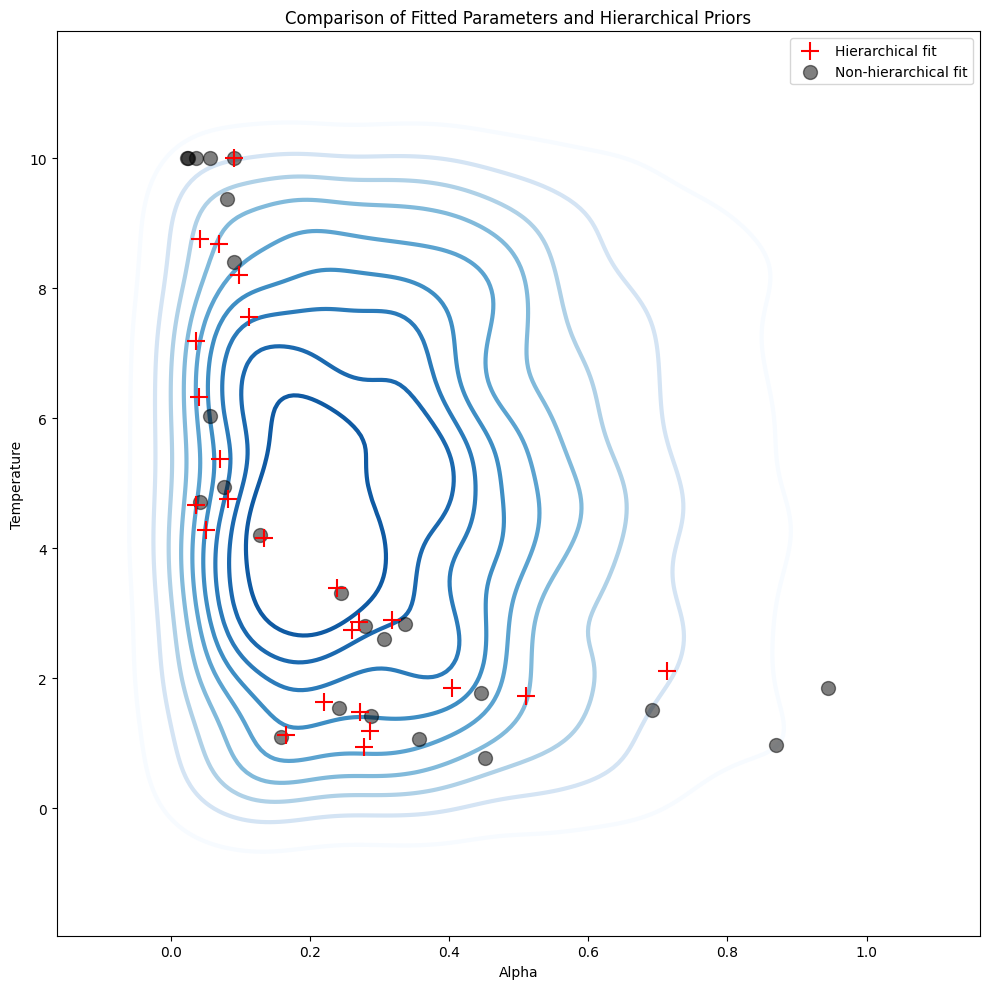

In [ ]:
from scipy.stats import truncnorm

best_hyperparameters = hyperparameters[hyperparameters["lme"] == hyperparameters["lme"].max()]
alpha_mean = best_hyperparameters[best_hyperparameters["parameter"] == "alpha"]["mean"].values[0]
alpha_sd = best_hyperparameters[best_hyperparameters["parameter"] == "alpha"]["sd"].values[0]
temperature_mean = best_hyperparameters[best_hyperparameters["parameter"] == "temperature"]["mean"].values[0]
temperature_sd = best_hyperparameters[best_hyperparameters["parameter"] == "temperature"]["sd"].values[0]

num_samples = 5000

fig =  plt.figure(figsize=(10, 10))

numpy.random.seed(984777324)
# For alpha: lower=0, upper=1
a_alpha = (0 - alpha_mean) / alpha_sd
b_alpha = (1 - alpha_mean) / alpha_sd
samples_alpha = truncnorm.rvs(a=a_alpha, b=b_alpha, loc=alpha_mean, scale=alpha_sd, size=num_samples)

# For temperature: lower=0, upper=10
a_temp = (0 - temperature_mean) / temperature_sd
b_temp = (10 - temperature_mean) / temperature_sd
samples_temperature = truncnorm.rvs(a=a_temp, b=b_temp, loc=temperature_mean, scale=temperature_sd, size=num_samples)

plt.scatter(x=parameters_hierarchical.alpha, y=parameters_hierarchical.temperature, color='red', label='Fitted Parameters', s=150, zorder=4, marker='+')
plt.scatter(x=parameters_no_prior.alpha, y=parameters_no_prior.temperature, color='black', label='Fitted Parameters', s=100, zorder=3, marker='o', alpha=0.5)
sns.kdeplot(x=samples_alpha, y=samples_temperature, cmap="Blues", thresh=0.05, linewidths=3)

plt.xlabel('Alpha')
plt.ylabel('Temperature')
plt.title('Comparison of Fitted Parameters and Hierarchical Priors')
plt.legend(['Hierarchical fit', 'Non-hierarchical fit', 'Hierarchical prior (KDE)'])
plt.tight_layout()



So let me explain the figure here. The two axes are the two parameters. The density contours plot the  prior distributions of the parameters, which are the blue lines. The countours show the density of the prior distribution, with darker areas indicating higher density. The red dots are the estimates of the parameters from the hierarchical model, and the green dots are the estimates of the parameters from the non-hierarchical model.

# Questions

- What do you notice here?
- What is the main change compared to the previous model?
- How do the parameters compare to the previous model?